# 預測電廠每小時電能輸出

## 數據介紹
我們將要構建預測電廠每小時電能輸出的迴歸模型。我們所用的數據來自於土耳其的研究者 Pınar Tüfekci 和 Heysem Kaya，數據可以在這裏下載到（https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
）。因爲數據是以.xlsx 的形式存儲的，所以我們使用 pandas 的 read_excel() 函數來讀取它：

In [1]:
import pandas as pd
electricity = pd.read_excel('Folds5x2_pp.xlsx')
print(electricity.info())
electricity.head(3)

# ambient temperature
# exhaust vacuum
# ambient pressure
# relative humidity
# electrical energy output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


PE 這一列是目標變量，它描述的是每小時的電能輸出淨值。其他所有變量都是潛在特徵，每個變量實際上都是每小時的平均值（而不像 PE 一樣是淨值）

## 確定訓練集的大小
我們首先確定用來生成學習曲線的訓練集的大小。
最小值是 1，最大值是訓練集的樣本總數。我們的訓練集共有 9568 個樣本，所以最大值是 9568。
然而，我們還沒有設置好驗證集。我們將會使用 80:20 的比例來設置訓練集和驗證集，最終我們的訓練集有 7654 個樣本（80%），驗證集有 1914 個樣本（20%），用來生成學習曲線的訓練集的最大樣本數就是 7654。
應該注意，每個特定大小的訓練集都會訓練一個新的模型。如果你使用了交叉驗證，也就是我們在本文中使用的方法，那麼每個訓練集大小會訓練出 k 個不同的模型（k 是交叉驗證的次數）。爲了節省代碼的運行時間，將交叉驗證設置到 5-10 是比較現實的。

我們將使用 scikit-learn 中的 learning_curve() 函數來生成一個迴歸模型的學習曲線。不需要我們自己設置驗證集，learning_curve() 函數會自己完成這個任務。
在下面的代碼中，我們執行了以下幾點：
* 從 sklearn 中完成需要的 import；
* 聲明特徵和目標；
* 使用 learning_curve() 函數生成需要的數據來繪製學習曲線。函數會返回一個包含三個元素的元組：訓練集大小、訓練集和驗證集上的誤差得分。在這個函數內部，我們使用了以下參數：
* estimator-代表我們估計實際模型時所用的學習算法；
* X-包含特徵的數據；
* y-包含目標的數據；
* train_sizes—所用的特定的訓練集大小；
* cv-確定交叉驗證分割策略（我們馬上會討論這個內容）；
* scoring-代表所用的誤差指標；我們使用 nearest proxy 和負 MSE，我們隨後必須顛倒一下符號。

In [2]:
# 以下 6 種大小的訓練集
train_sizes = [1, 100, 500, 2000, 5000, 7654]
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
features = ['AT', 'V', 'AP', 'RH']
target = 'PE'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(), X = electricity[features],
y = electricity[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [3]:
# 我們已經知道了什麼是 train_sizes。現在讓我們來查看一下 learning_curve() 函數返回的
# 另外兩個變量：
print('Training scores:\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('nValidation scores:\n', validation_scores)
train_sizes

Training scores:
 [[ -0.          -0.          -0.          -0.          -0.        ]
 [-19.71230701 -18.31492642 -18.31492642 -18.31492642 -18.31492642]
 [-18.14420459 -19.63885072 -19.63885072 -19.63885072 -19.63885072]
 [-21.53603444 -20.18568787 -19.98317419 -19.98317419 -19.98317419]
 [-20.47708899 -19.93364211 -20.56091569 -20.4150839  -20.4150839 ]
 [-20.98565335 -20.63006094 -21.04384703 -20.63526811 -20.52955609]]

 ----------------------------------------------------------------------
nValidation scores:
 [[-619.30514723 -379.81090366 -374.4107861  -370.03037109 -373.30597982]
 [ -21.80224219  -23.01103419  -20.81350389  -22.88459236  -23.44955492]
 [ -19.96005238  -21.2771561   -19.75136596  -21.4325615   -21.89067652]
 [ -19.92863783  -21.35440062  -19.62974239  -21.38631648  -21.811031  ]
 [ -19.88806264  -21.3183303   -19.68228562  -21.35019525  -21.75949097]
 [ -19.9046791   -21.33448781  -19.67831137  -21.31935146  -21.73778949]]


array([   1,  100,  500, 2000, 5000, 7654])

因爲我們指定了 6 個不同的訓練集大小，你或許期望看到每個誤差得分有 6 個結果。然而，我們得到結果是每個誤差得分對應着 6 行數字，每行有 5 個誤差得分。
出現這個結果的原因是 learning_curve() 函數運行了 k-fold 交叉驗證, 其中 k 的值是通過我們所賦的 cv 參數指定的。

爲了畫出學習曲線，對於每個訓練集大小，我們只需要一個誤差得分。基於這個原因，在下面的代碼中我們會對每一行中的值求平均值，並且顛倒誤差得分的符號（正如前面討論過的一樣）：

In [4]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scoresnn:\n', pd.Series(train_scores_mean, index = train_sizes))
print('n', '-' * 20) # separator
print('nMean validation scoresnn',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scoresnn:
 1       -0.000000
100     18.594403
500     19.339921
2000    20.334249
5000    20.360363
7654    20.764877
dtype: float64
n --------------------
nMean validation scoresnn 1       423.372638
100      22.392186
500      20.862362
2000     20.822026
5000     20.799673
7654     20.794924
dtype: float64


現在我們已經有了所有的數據了，只需要畫出學習曲線。

然而，在繪製學習曲線之前，我們需要停下來做一個重要的觀察。也許你已經注意到了，在有些不同大小的訓練集上，誤差得分是相同的。對於訓練集樣本數爲 1 的那一行，出現這種情況並不意外，（因爲都是 0），但是對於其他行呢？除了最後一行，我們有很多相同的值。例如，第二行中有很多值是和第二列相同的，爲什麼會這樣呢？

這是由於沒有對每一份訓練集做隨機化處理形成的。讓我們在下表的幫助下看看下一個例子。當我們的訓練集大小是 500 的時候，前 500 個樣本被選擇。對於第一次分割，這 500 個樣本會從第二塊中選擇。從第二次分割開始，這 500 個樣本都將從第一塊中選擇。因爲我們沒有隨機化訓練集，從第二次分割時，這 500 個樣本都是一樣的。這能夠合理解釋前面提到的在 500 個訓練樣本的訓練集中，從第二次分割開始所有的誤差得分都是一樣的結果。

![title](validation_set.png)

同樣的推理能夠適用於 100 個樣本的情況，類似的推理也適用於其他情況。

爲了消除這種現象，我們需要在 learning_curve() 函數中將 shuffle 參數設置爲 true。這就能夠將訓練集中的每一次分割的數據索引隨機化。我們之前沒有做隨機處理的原因是：

* 數據集文檔中已有說明，數據進行了 5 次隨機化處理，所以這裏沒有必要再做隨機化處理。
* 我想讓你瞭解這種看起來很奇怪的現象，以免在實踐的過程中困在這個問題上。

最後，我們繪製學習曲線。

## 高 bias 和低 variance

(0, 40)

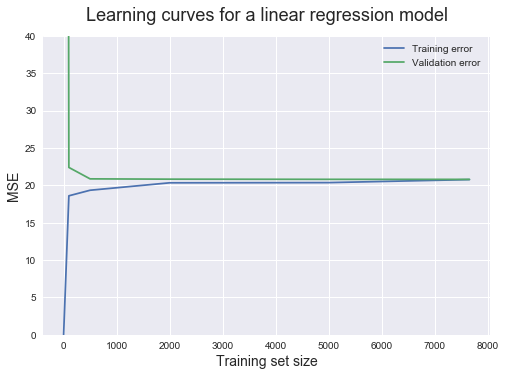

In [5]:
# 我們使用常規的 matplotlib 流程來繪製學習曲線：

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

我們可以從這幅圖中提煉出很多信息。下面我們詳細探討：

當訓練集的大小是 1 的時候，我們可以看到訓練集中的 MSE 是 0。這是很正常的情況，因爲模型能夠完美地適應一個數據點，在訓練集中的預測結果是完美的。

但是在驗證集上（驗證集有 1914 個樣本）測試模型的時候，MSE 會劇烈增長到 423.4。由於這個值特別大，所以我們將 Y 軸的區間限制在了 0 到 40。這讓我們能夠準確地讀到大多數 MSE。因爲一個僅在單個樣本上訓練得到的模型是極其不可能泛化到 1914 個從未見過的新樣本上的，所以這個結果也在預料之中。

當訓練集樣本數爲 100 的時候，訓練過程的 MSE 會急劇增大，而驗證過程的 MSE 會減小。這個線性迴歸模型不能完美地預測所有的 100 個數據點，所以 MSE 會大於 0。然而，此時訓練集的性能仍然優於驗證集，這是由於在驗證集上估計了更多的數據。

從 500 個數據點開始，驗證集的 MSE 能夠保持大致不變。這給我們一個重要信息：增加更多的訓練數據點也不會帶來更好的模型。所以與其浪費時間（金錢）來收集數據，我們更需要的是做點其他事情，例如嘗試一下能夠構建更加複雜模型的算法。

![](learn_curve_1.png)

爲了避免誤解概念，需要注意的很重要的一點是：增加更多的訓練數據樣本確實是無濟於事的。然而，增加更多的特徵就是另外一回事了，因爲增加特徵能夠增加模型的複雜度。

現在我們來討論一下 bias 和 variance 的診斷。bias 問題的主要標誌是較高的驗證誤差。在我們的例子中，驗證 MSE 保持在接近 20 的值。但是這個值有多好呢？

從技術角度而言，大小爲 20 的 MSE 的單位是兆瓦特^2（MW^2）（因爲計算 MSE 的時候取了平方）。但是我們目標列中的數值是以 MW 爲單位的。給 20MW^2 取平方根，得到的近似值是 4.5MW。每個目標值代表的是一小時的最終電能輸出。所以每小時我們的模型都會接近於 4.5MW 的平均值。Quora 有這麼一個答案，4.5MW 的能量相當於 4500 個手持吹風機產生的熱能。如果我們要預測更長時間（比如一天或者更長時間）的電能輸出的時候，這種誤差會更大。

由此可以確定，20MW^2 的 MSE 是相當大的。所以我們的模型存在 bias 問題。但是它是一個低 bias 問題呢還是高 bias 問題呢？

爲了找到這個答案，我們需要注意一下訓練誤差。如果訓練誤差特別小，這就說明估計模型能夠很好地擬合訓練數據，這就是說模型在對應的數據集上有較小的 bias。



![title](learn_curve_2.png)

如果訓練誤差比較高，就說明估計模型不能很好地擬合訓練數據，也就意味着在對應的數據集上有較高的 bias。

在我們的例子中，訓練過程的 MSE 穩定在 20MW^2 左右。我們在前面分析過，這是一個相當高的誤差得分。因爲驗證過程的 MSE 比較高，所以訓練 MSE 也是比較高的，我們的模型就有一個較高的 bias 問題。

現在讓我們診斷一下最終的 variance 問題。對 variance 的估計可以通過以下兩種方式完成：

* 通過檢查驗證學習曲線和訓練學習曲線之間的差距；
* 通過檢查訓練誤差：檢查誤差的值隨着訓練樣本數增加的變化。

![title](learn_curve_3.png)

較小的差距代表較小的 variance。通常，差距越小，variance 越小。反之亦然：差距越大，variance 越大。

正如我們之前觀察到的一樣，如果 variance 比較大，那麼說明模型過於擬合訓練數據了。當模型過擬合的時候，它在泛化到從未見過的數據上時會存在問題。當這樣一個模型分別在訓練集和驗證集上測試的時候，訓練誤差會比較低，驗證誤差通常會比較高。當我們改變訓練集大小的時候，這種模式會繼續存在，訓練集和驗證集之間的差距會決定這兩個學習曲線之間的距離。

訓練誤差和驗證誤差之間的關係，以及訓練學習曲線和驗證學習曲線之間的差距可以總結如下：

gap=validation error−training error

兩個誤差之間的差距越大，曲線之間的距離越大，variance 越大。

在我們的情況中，曲線之間的差距是比較小的，所以我們可以穩妥地說，模型的 variance 是比較低的。

高的訓練 MSE 得分也是一個快速檢測低 variance 的方式。如果學習算法的 variance 比較低，那麼當我們改變訓練集的時候算法會生成比較簡單並且比較相似的模型。因爲模型過於簡單，它們甚至不能很好的擬合訓練數據集（欠擬合）。所以這種情況應該是較高的訓練 MSE。所以，高訓練 MSE 可以作爲低 variance 的標誌。

![title](learn_curve_4.png)

在我們的例子中，訓練 MSE 大約穩定在 20，我們已經證明過，這是一個很高的值。所以，除了較小的學習曲線差距之外，我們可以使用較大的訓練誤差來確認模型具有較低 variance 問題。

目前，我們可以總結如下：

* 我們的學習算法會遇到這幾個問題:高 bias，低 variance，以及對訓練數據的欠擬合。
* 在目前的學習算法下，增加更多的訓練樣本極不可能得到更好的模型。
在這種情形下我們的解決方案是轉向一個更加複雜的學習算法。這應該能夠降低 bias，並增加 variance。嘗試增加訓練樣本的數量是一個誤區。

通常，以下兩種修正方式在處理高 bias 和低 variance 的問題時會比較奏效：

* 用更多的特徵訓練當前的學習算法，即通過增加模型的複雜度來降低 bias。
* 減少對當前算法的正則化。簡言之，正則化能夠避免算法在訓練數據上過擬合。如果我們減少了正則化，模型會更好地擬合訓練數據，所以，就會增加 variance，降低 bias。

## 低 bias 和高 variance

讓我們看一下未正則化的隨機森林迴歸器是如何運行的。我們使用和前面相同的流程生成學習曲線。這一次我們會將所有的內容封裝在一個函數中，以便以後使用。作爲對照，我們也會展示出線性迴歸模型的曲線。

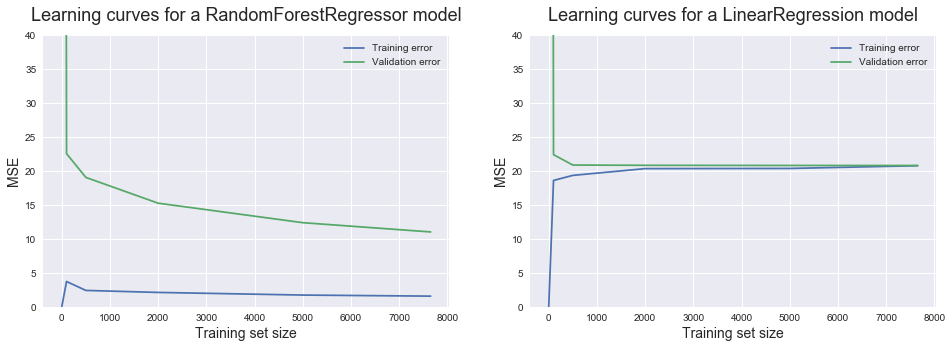

In [6]:
### Bundling our previous work into a function 
def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes = train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)
    
    
### Plotting the two learning curves 
from sklearn.ensemble import RandomForestRegressor
plt.figure(figsize = (16,5))
    
for model, i in [(RandomForestRegressor(), 1), (LinearRegression(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, electricity, features, target, train_sizes, 5)

觀察學習曲線，我們可以發現已經成功地降低了 bias。雖然還存在很明顯的 bias，但是已經不像之前那麼大了。觀察訓練曲線我們可以判斷，這次的模型具有較低的 bias 問題。

兩條曲線之間的差距表明模型的 variance 有着大幅度的增大。較小的訓練 MSE 證實了對高 variance 的判斷。

較大的曲線差距和較低的訓練誤差同樣也標誌着過擬合問題的存在。當模型在訓練集上性能較好，而在測試集上性能很差的時候，就是過擬合問題。

我們在這裏還能觀察到的另一個重要現象就是：增加新的訓練樣本很可能能夠得到更好的模型。驗證學習曲線並沒有穩定在使用最大訓練樣本量的地方。它還有繼續降低，朝着訓練學習曲線收斂的潛力，這和我們在線性迴歸模型的情況中看到的收斂是類似的。

目前，我們可以得到如下結論：

* 隨機森林出現了較高的 variance 和相當低的 bias，以及在訓練集上的過擬合問題。
* 在目前的學習算法下，增加更多的學習樣本非常有可能得到更好性能的模型。
至此，我們可以做以下的事來改善我們的模型：

* 增加更多的訓練樣本
* 爲目前所用的算法增加正則化。這會增加模型的 bias，降低模型的 variance。
* 減少我們目前在訓練及數據中所用的特徵數。算法仍舊會很好地適應訓練集，但是由於特徵數目減少了，算法會構建相對簡單的模型。這應該能夠增加模型的 bias，降低模型的 variance。
我們還是要對隨機森林算法嘗試一下正則化。方式之一就是調整每個決策樹葉子節點的最大值。這可以通過使調整 RandomForestRegressor() 函數的 max_leaf_nodes 參數來實現。你沒有必要理解這個正則化技術。我們的目標是使你能夠注意正則化對學習曲線帶來的影響。

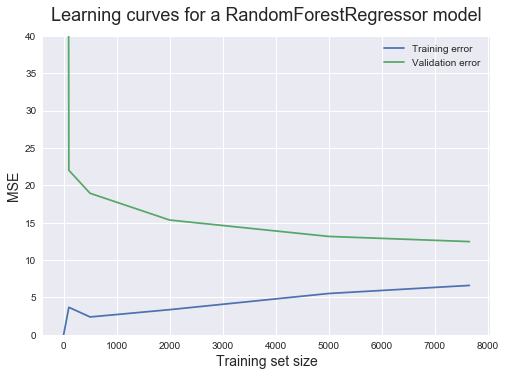

In [7]:
learning_curves(RandomForestRegressor(max_leaf_nodes = 350), electricity, features, target, train_sizes, 5)

還不錯，訓練學習曲線和測試學習曲線之間的差距縮小了。bias 好像增大了一些，這正是我們想要的結果。

但是我們的工作還未結束。驗證過程的 MSE 還有繼續降低的潛力。爲了達到這個目標，還有一些可以做的工作：

* 增加更多的訓練樣本
* 增加特徵
* 特徵選擇
* 超參數優化

## 理想化的學習曲線和不可約化的誤差

這兩種學習曲線構成了一個可以對機器學習過程中的模型進行快速檢查的很好的工具，那麼我們怎麼知道何時停止呢？怎麼識別完美的學習曲線呢？

對於我們之前的迴歸例子，你也許會認爲最好的情形應該是兩條學習曲線都收斂至 MSE 爲 0 的時候。那是完美的情況，可是事實上，很不幸這是不可能的。無論是從實踐角度還是理論角度。這是由於不可約誤差（irreducible error）的存在。

當我們構建一個能夠映射特徵 X 和目標 Y 的關係的模型時，我們首先會假設存在這麼一個關係。在假設正確的條件下，會存在一個能夠完美描述 X 和 Y 之間關係的模型，就像這樣：

Y=f(X)+irreducible error （1）

可是這裏爲啥會有一個 error 項呢？我們不是說 f 能夠完美地描述 X 和 Y 之間的關係嗎？

存在誤差的原因是 Y 並不是我們所擁有的有限特徵 X 的函數。還有更多的特徵能夠影響 Y。而我們沒有這些特徵。還有可能是這種情況：X 包含測量誤差，所以 Y 也是一個不可約誤差的函數。

現在我們解釋一下這個誤差不可約的原因。當我們用 f^(X) 估計 f(X) 時，我們引入另一個誤差—可約誤差（reducible error）。

f(X)=^f(X)+reducible error （2）

將公式（1）中的 f(X) 替換掉，我們得到下面的式子：

Y=^f(X)+reducible error+irreducible error （3）

可約誤差可以通過構建更好的模型來減小。從方程（2）中我們可以發現：如果可約誤差變成 0，我們的估計模型 f^(X) 等於真實模型了。然而，從方程（3）中我們可以看到，即使可約誤差變成了 0，不可約誤差仍舊存在。這就是這個誤差被稱作不可約誤差的原因。

這告訴我們，在實際中性能最好的模型會收斂於某個不可約誤差，而不是理想的誤差值（對於 MSE，理想的誤差值是 0；我們將會看到，其他的誤差值會有和 MSE 不同的理想值）。

![title](learn_curve_5.png)

在實際中，不可約誤差的準確值幾乎總是未知的。我們也假設不可約誤差和 X 是獨立的。這意味着我們不能使用 X 來尋找真實的不可約誤差。用更加嚴密的數學語言描述，就是：不存在從 X 到不可約誤差之間的映射函數 g。

irreducible error≠g(X)

所以，沒有辦法基於我們所擁有的數據來知道不可約誤差的真實值。實際上，最佳應對方法就是嘗試得到儘可能小的誤差得分，同時要記得：誤差得分的極限是某個給定的不可約誤差。

## 對於分類問題，又是怎麼樣的呢？

目前，我們已經瞭解了迴歸問題中的學習曲線。對於分類任務，這個過程幾乎是一樣的。主要的區別就是：我們必須選擇另一個誤差度量--一個能夠用來衡量分類器性能的度量。讓我們看一個例子：

![title](learn_curve_6.png)

與我們之前看到的不一樣的是，你要注意到訓練學習曲線位於驗證學習曲線上方。這是因爲我們使用的誤差得分是準確率，用準確率來描述模型的性能。準確率越高，模型性能越好。而 MSE 是在描述模型有多差。MSE 越小，模型性能越好。

這幅圖中也存在不可約誤差的含義。對於描述模型有多差的度量指標而言，不可約誤差是以下限的形式存在：實際模型不可能比它還低。對於描述模型有多好的度量指標而言，不可約誤差是以上限的形式存在：實際模型不可能比它高。

要注意的一點是，在更多數技術性寫作中，貝葉斯誤差通常指的是分類器的可能最佳錯誤得分。這個概念和不可約誤差是類似的。

## 後續內容
在任何監督學習算法中，學習曲線構成了診斷模型 bias 和 variance 的很好工具。我們已經學到了如何使用 scikit-learn 和 matplotlib 來生成學習曲線，以及如何使用學習曲線來診斷模型的 bias 和 variance。

爲了強化你所學到的內容，可以考慮以下的內容：

* 使用另一個數據集爲迴歸模型生成學習曲線；
* 爲分類任務生成學習曲線；
* 不使用 learning_curve() 函數，手寫代碼，從 0 開始得到一個監督學習任務的學習曲線。可選擇交叉驗證；
* 對比一下使用交叉驗證和未使用交叉驗證的學習曲線。這兩種曲線應該對應同一個學習算法（數據也應該是一樣的）。